<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "3E"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/3E/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


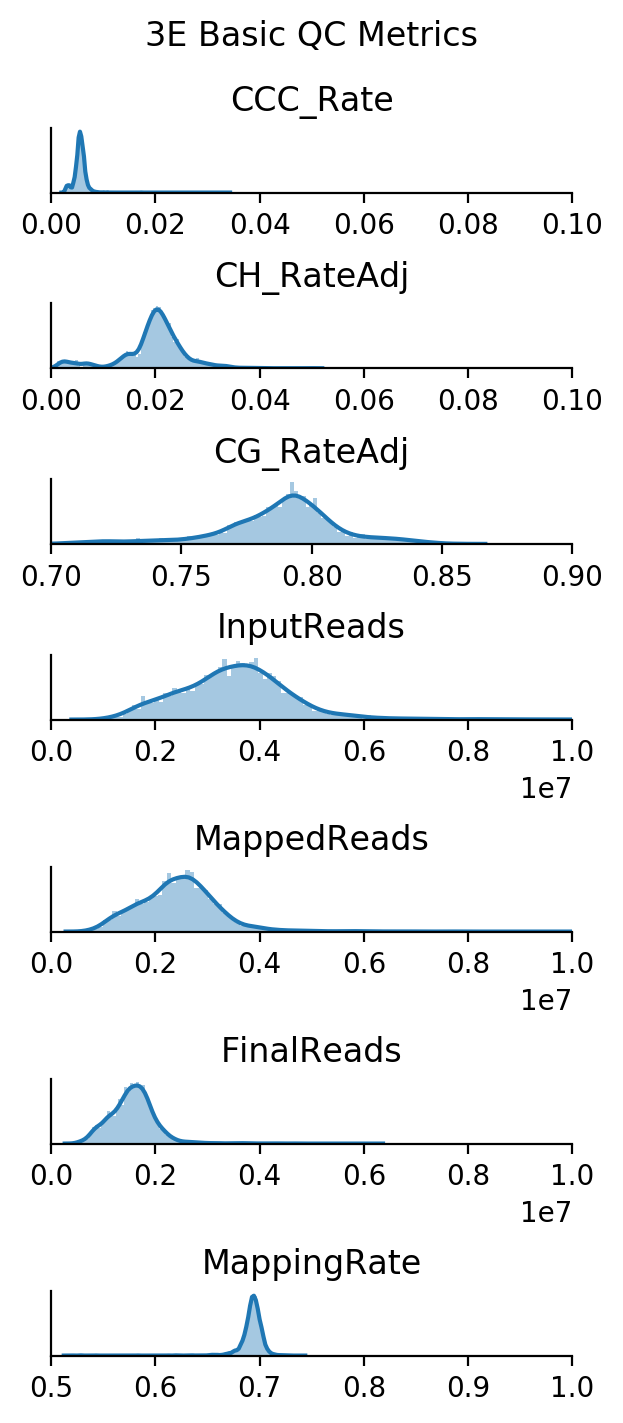

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

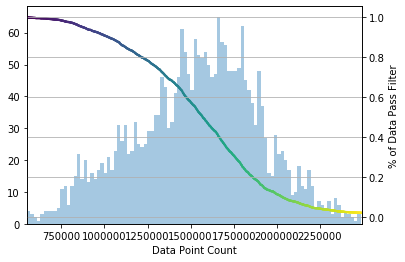

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2516/2516 (100.0%)
CG_RateAdj passed 2516/2516 (100.0%)
CH_RateAdj passed 2516/2516 (100.0%)
FinalReads passed 2516/2516 (100.0%)
MappingRate passed 2516/2516 (100.0%)
Overall passed 2516/2516 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180320 1334
180326 1182


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 325 84.6%
ad002 311 81.0%
ad004 326 84.9%
ad006 318 82.8%
ad007 315 82.0%
ad008 307 79.9%
ad010 313 81.5%
ad012 301 78.4%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
3E_M_0,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.00680,0.81684,0.81559,0.03682,0.03023,1890354.0,4226556,2934849.0,3E,...,-27.592617,5.709239,4.897816,-23.856043,MGE-Pvalb Thsd7a,-1.414931,-4.991824,9.262171,-17.954522,True
3E_M_1,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.00592,0.79244,0.79120,0.02817,0.02238,1676858.0,3780150,2607973.0,3E,...,-6.724967,9.621551,46.865681,-4.511196,OLF-Exc Sgcd,-4.387807,4.304490,33.783798,20.284866,True
3E_M_10,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.00590,0.79286,0.79163,0.02746,0.02169,2352020.0,5217032,3659530.0,3E,...,0.881757,6.669678,23.225708,-41.182247,OLF-Exc Bmpr1b,6.346426,-7.938768,-0.601181,-9.538306,True
3E_M_100,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.00326,0.66318,0.66208,0.00597,0.00272,2391212.0,5408260,3776638.0,3E,...,7.799703,11.768573,-67.860446,-6.493657,PC pc-all,-0.741238,6.245041,1.207292,1.814973,True
3E_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.00506,0.76833,0.76715,0.02263,0.01766,993862.0,2102098,1448202.0,3E,...,-2.234399,9.908834,-1.549409,-54.206170,OLF-Exc Unc13c,-0.749312,-5.839015,-0.495722,8.534514,True
3E_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.00524,0.79026,0.78916,0.02446,0.01932,1248209.0,2746414,1833614.0,3E,...,-0.841924,11.181529,12.161037,-56.088436,OLF-Exc Lrrtm3,2.786595,-2.767383,-22.862937,28.044896,True
3E_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.00580,0.81325,0.81216,0.02689,0.02121,1248451.0,2686808,1845639.0,3E,...,23.650595,9.143574,-24.308920,-29.164126,CT-L6 Megf9,-1.024458,-15.476998,-8.442926,-6.026278,True
3E_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.00509,0.80141,0.80039,0.02473,0.01974,1242274.0,2694718,1857404.0,3E,...,-6.560532,8.055650,42.005901,-6.236036,OLF-Exc Sgcd,-5.196309,2.278273,24.492802,40.002894,True
3E_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.00635,0.79853,0.79724,0.03077,0.02458,1178046.0,2587608,1772889.0,3E,...,1.472690,7.397981,16.268874,-35.020000,OLF-Exc Cux2,4.997792,-9.596432,-10.724657,-5.774460,True
3E_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/3E/CEMBA180320_3E...,0.00540,0.78239,0.78121,0.02605,0.02076,1113469.0,2463206,1680532.0,3E,...,0.428162,6.870572,19.737454,-34.217768,OLF-Exc Cdh9,2.670033,-14.379126,-38.694433,-11.370558,True
